In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import external libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# initialization
from objfun_node2vec import N2V
n2v = N2V('../data/clear_cluster_test/one_eighth.csv',
            '../data/clear_cluster_test/labels.csv')

TODO:
__Simulated annealing__ vs __Fast simulated annealing__

In [4]:
from heur_fsa import FastSimulatedAnnealing
from heur_aux import Correction, CauchyMutation

In [5]:
NUM_RUNS = 50 
maxeval = 50 

In [6]:
default_params=[1., 10, 80, 10]
# opt_params=[2., 10, 100, 5] # known from the previous experiments optimal paremeters 

### Node2vec optimisation using FSA

In [7]:
def experiment_fsa(of, maxeval, num_runs, T0, n0, alpha, r, params):
    results = []
    for i in tqdm(range(num_runs), 'Testing T0={}, n0={}, alpha={}, r={}'.format(T0, n0, alpha, r)):
        mut = CauchyMutation(r=r, correction=Correction(of))
        result = FastSimulatedAnnealing(of, maxeval=maxeval, 
                                        T0=T0, n0=n0, alpha=alpha, 
                                        mutation=mut,params=params).search()
        result['run'] = i
        result['heur'] = 'FSA_{}_{}_{}_{}'.format(T0, n0, alpha, r) # name of the heuristic
        result['T0'] = T0
        result['n0'] = n0
        result['alpha'] = alpha
        result['r'] = r
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'T0', 'n0', 'alpha', 'r', 'best_x', 'best_y', 'neval'])

In [8]:
table_fsa = pd.DataFrame()

for T0 in [1e-10, 1e-2, 1, np.inf]: 
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, 
                         T0=T0, n0=1, alpha=2, r=0.5,params=default_params)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [9]:
table_fsa.head()

heur  run            T0  n0  alpha    r  \
0  FSA_1e-10_1_2_0.5    0  1.000000e-10   1      2  0.5   
1  FSA_1e-10_1_2_0.5    1  1.000000e-10   1      2  0.5   
2  FSA_1e-10_1_2_0.5    2  1.000000e-10   1      2  0.5   
3  FSA_1e-10_1_2_0.5    3  1.000000e-10   1      2  0.5   
4  FSA_1e-10_1_2_0.5    4  1.000000e-10   1      2  0.5   

                                     best_x    best_y  neval  
0   [[1.6187386246265323], 1.0, 10, 80, 10]  0.450382    inf  
1  [[0.14831554722947535], 1.0, 10, 80, 10]  0.406250    inf  
2   [[1.0009825134048458], 1.0, 10, 80, 10]  0.377778    inf  
3  [[0.32646452930716313], 1.0, 10, 80, 10]  0.375000    inf  
4      [3.590537838471784, 1.0, 10, 80, 10]  0.425781    inf

In [10]:
ax = sns.boxplot(x="T0", y="best_y", data=table_fsa)

In [11]:
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)

def mne(x):
    return np.mean([n for n in x if n < np.inf])

def feo(x):
    return mne(x)/rel(x)

In [12]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0'],
    
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0'])

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur            T0   feo  mne   rel
2  FSA_1e-10_1_2_0.5  1.000000e-10  50.0  1.0  0.02
0   FSA_0.01_1_2_0.5  1.000000e-02   NaN  NaN  0.00
1      FSA_1_1_2_0.5  1.000000e+00  50.0  1.0  0.02
3    FSA_inf_1_2_0.5           inf   NaN  NaN  0.00

__CHANGE__
The results are not various. Heuristics with t_0 = 1e-2 and t_0 = 1 did not get the optimal value. 
Since FSA with small and infinite initial temperatures perfored equaly according to FEO creterium, let's analyse deeper the 

## Analysis

### Can we improve the best configuration ($T_0=1e-10$)?

In [22]:
# maxeval 1000
heur = FastSimulatedAnnealing(n2v, maxeval=maxeval, T0=1e-10, n0=1, alpha=2, 
                              mutation=CauchyMutation(r=0.5, correction=Correction(n2v)),
                             params=default_params)
result = heur.search()
print('neval = {}'.format(result['neval']))
print('best_x = {}'.format(result['best_x']))
print('best_y = {}'.format(result['best_y']))

neval = inf
best_x = [array([4.125]), 1.0, 10, 80, 10]
best_y = 0.3333333333333333


In [23]:
log_data = result['log_data'].copy()
log_data = log_data[['step', 'x', 'f_x', 'y', 'f_y', 'T', 'swap']]  # column re-ordering, for better readability
log_data.head(10)

step                     x       f_x                     y       f_y  \
0     0               3.80153  0.128676  [2.5400654139646712]  0.265306   
1     1  [2.5400654139646712]  0.265306   [1.198963503444385]  0.265306   
2     2  [2.5400654139646712]  0.265306    [3.26135613574748]  0.265306   
3     3    [3.26135613574748]  0.265306    [3.34414661137345]  0.222222   
4     4    [3.26135613574748]  0.265306  [3.1197508137503793]  0.265306   
5     5  [3.1197508137503793]  0.265306   [3.796369852271816]  0.260714   
6     6  [3.1197508137503793]  0.265306  [3.3900973595700696]  0.222222   
7     7  [3.1197508137503793]  0.265306  [3.1282522195164715]  0.265306   
8     8  [3.1282522195164715]  0.265306  [3.2356848563015865]  0.265306   
9     9  [3.1282522195164715]  0.265306  [1.8774924145691791]  0.265306   

              T   swap  
0  1.000000e-10   True  
1  5.000000e-11  False  
2  2.000000e-11   True  
3  1.000000e-11  False  
4  5.882353e-12   True  
5  3.846154e-12  False  
6  2.702703e-12  False  
7  2.000000e-12   True  
8  1.538462e-12  False  
9  1.219512e-12  False

In [24]:
def plot_compare(step_data, ax1_col, ax1_label, ax2_col, ax2_label):
    fig, ax1 = plt.subplots()

    k = step_data.index.values
    T = step_data[ax1_col]
    ax1.plot(k, T, 'b-')
    ax1.set_xlabel('Step')
    ax1.set_ylabel(ax1_label, color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')

    ax2 = ax1.twinx()
    s2 = step_data[ax2_col]
    ax2.plot(k, s2, 'r.')
    ax2.set_ylabel(ax2_label, color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')

    plt.show()

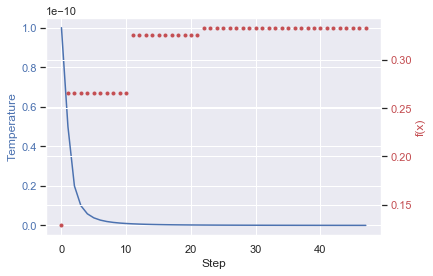

In [25]:
plot_compare(log_data, 'T', 'Temperature', 'f_x', 'f(x)')

In [26]:
plot_compare(log_data, 'T', 'Temperature', 'f_y', 'f(y)')

### Slower cooling?
Let's double $n_0$:

In [27]:
# maxeval=50
heur = FastSimulatedAnnealing(n2v, maxeval=maxeval, T0=1e-10, n0=2, alpha=2, 
                              mutation=CauchyMutation(r=0.5, correction=Correction(n2v)),
                             params=default_params)
result = heur.search()
print('neval = {}'.format(result['neval']))
print('best_x = {}'.format(result['best_x']))
print('best_y = {}'.format(result['best_y']))

neval = inf
best_x = [1.2626445132562205, 1.0, 10, 80, 10]
best_y = 0.585820895522388


In [28]:
log_data = result['log_data'].copy()
log_data = log_data[['step', 'x', 'f_x', 'y', 'f_y', 'T', 'swap']]  
# column re-ordering, for better readability

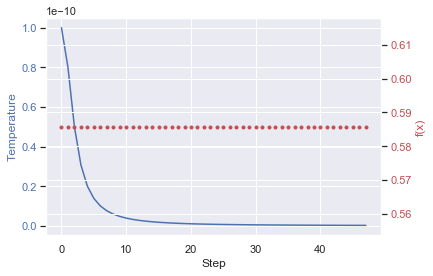

In [29]:
plot_compare(log_data, 'T', 'Temperature', 'f_x', 'f(x)')

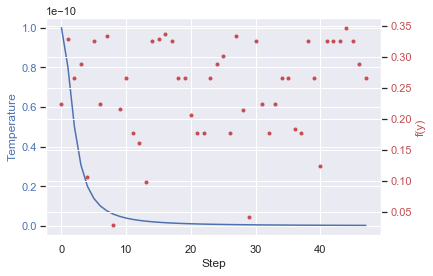

In [30]:
plot_compare(log_data, 'T', 'Temperature', 'f_y', 'f(y)')

__More thorough testing:__

In [31]:
# cooling strategy parameter testing
for n0 in [2, 3, 5, 10]:
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, T0=1e-10, n0=n0, alpha=2, r=0.5,
                        params=default_params)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [32]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0', 'n0'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0', 'n0'])

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur            T0  n0   feo  mne   rel
3   FSA_1e-10_1_2_0.5  1.000000e-10   1  50.0  1.0  0.02
4   FSA_1e-10_2_2_0.5  1.000000e-10   2   NaN  NaN  0.00
5   FSA_1e-10_3_2_0.5  1.000000e-10   3  25.0  1.0  0.04
6   FSA_1e-10_5_2_0.5  1.000000e-10   5  25.0  1.0  0.04
2  FSA_1e-10_10_2_0.5  1.000000e-10  10  25.0  1.0  0.04
0    FSA_0.01_1_2_0.5  1.000000e-02   1   NaN  NaN  0.00
1       FSA_1_1_2_0.5  1.000000e+00   1  50.0  1.0  0.02
7     FSA_inf_1_2_0.5           inf   1   NaN  NaN  0.00

__Is the mutation $r$ adequate?__

In [33]:
log_data['jump_length'] = log_data.apply(lambda r: np.linalg.norm(r['x'] - r['y']), axis=1)
log_data.head(10)

step         x       f_x                      y       f_y             T  \
0     0  1.262645  0.585821   [1.6622774203713457]  0.224490  1.000000e-10   
1     1  1.262645  0.585821  [0.47725558775117816]  0.328671  8.000000e-11   
2     2  1.262645  0.585821   [1.4873424064678944]  0.265306  5.000000e-11   
3     3  1.262645  0.585821   [0.9205657391577463]  0.287770  3.076923e-11   
4     4  1.262645  0.585821   [1.7465483812885165]  0.105263  2.000000e-11   
5     5  1.262645  0.585821                [0.125]  0.325581  1.379310e-11   
6     6  1.262645  0.585821   [1.6667518008692639]  0.224490  1.000000e-11   
7     7  1.262645  0.585821                [4.125]  0.333333  7.547170e-12   
8     8  1.262645  0.585821    [1.329397539970571]  0.027933  5.882353e-12   
9     9  1.262645  0.585821    [1.055785735356008]  0.215686  4.705882e-12   

    swap  jump_length  
0  False     0.399633  
1  False     0.785389  
2  False     0.224698  
3  False     0.342079  
4  False     0.483904  
5  False     1.137645  
6  False     0.404107  
7  False     2.862355  
8  False     0.066753  
9  False     0.206859

In [34]:
log_data['jump_length'].describe()

count    48.000000
mean      0.727042
std       0.596869
min       0.066753
25%       0.318033
50%       0.560860
75%       1.137645
max       2.862355
Name: jump_length, dtype: float64

In [35]:
for r in [0.001,0.01,.1, .25, .75, 1]:
    res = experiment_fsa(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, T0=1e-10, n0=5, alpha=2, r=r,
                        params=default_params)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [40]:
ax = sns.boxplot(x="r", y="best_y", data=table_fsa)

In [46]:
table_fsa['best_y'].mean()

0.5057760208262176

In [48]:
table_fsa['best_y'].median()

0.45038167938931295

In [49]:
table_fsa['best_y'].mode()

0    0.333333
dtype: float64

In [45]:
table_fsa['best_y'].max()

1.0

In [36]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0', 'n0', 'r'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0', 'n0', 'r'])

C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Adeliia\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


heur            T0  n0      r        feo  mne   rel
3     FSA_1e-10_1_2_0.5  1.000000e-10   1  0.500  50.000000  1.0  0.02
4     FSA_1e-10_2_2_0.5  1.000000e-10   2  0.500        NaN  NaN  0.00
5     FSA_1e-10_3_2_0.5  1.000000e-10   3  0.500  25.000000  1.0  0.04
6   FSA_1e-10_5_2_0.001  1.000000e-10   5  0.001        NaN  NaN  0.00
7    FSA_1e-10_5_2_0.01  1.000000e-10   5  0.010  16.666667  1.0  0.06
8     FSA_1e-10_5_2_0.1  1.000000e-10   5  0.100  12.500000  1.0  0.08
9    FSA_1e-10_5_2_0.25  1.000000e-10   5  0.250  50.000000  1.0  0.02
10    FSA_1e-10_5_2_0.5  1.000000e-10   5  0.500  25.000000  1.0  0.04
11   FSA_1e-10_5_2_0.75  1.000000e-10   5  0.750  50.000000  1.0  0.02
12      FSA_1e-10_5_2_1  1.000000e-10   5  1.000        NaN  NaN  0.00
2    FSA_1e-10_10_2_0.5  1.000000e-10  10  0.500  25.000000  1.0  0.04
0      FSA_0.01_1_2_0.5  1.000000e-02   1  0.500        NaN  NaN  0.00
1         FSA_1_1_2_0.5  1.000000e+00   1  0.500  50.000000  1.0  0.02
13      FSA_inf_1_2_0.5           inf   1  0.500        NaN  NaN  0.00

The best performing instance of FSA, according to $FEO$:

In [39]:
stats_fsa.sort_values(by=['feo']).head(5)

heur            T0  n0     r        feo  mne   rel
8    FSA_1e-10_5_2_0.1  1.000000e-10   5  0.10  12.500000  1.0  0.08
7   FSA_1e-10_5_2_0.01  1.000000e-10   5  0.01  16.666667  1.0  0.06
2   FSA_1e-10_10_2_0.5  1.000000e-10  10  0.50  25.000000  1.0  0.04
5    FSA_1e-10_3_2_0.5  1.000000e-10   3  0.50  25.000000  1.0  0.04
10   FSA_1e-10_5_2_0.5  1.000000e-10   5  0.50  25.000000  1.0  0.04

## Conclusion